In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import KFold

from model_tree import *
from reg_tree import *

from os import listdir
from os.path import isfile, join

# online source :https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

data_path = "../../../../machine learning/checkdatasets/PRSA_Data_20130301-20170228/"


files = [f for f in listdir(data_path)]

frames= []
for file in files:
    if file[-4:] == ".csv" :
        d = pd.read_csv(data_path+file)
        frames.append(d)

df = pd.concat(frames)

# for coding purpose, use a smaller dataset
df=df.sample(frac=0.1)

# only predict O3
df=df.drop(columns=['No','PM2.5', 'PM10', 'SO2', 'NO2', 'CO'])

# get attributes columns 
attributes = list(df.columns).copy()
attributes.remove('O3')

# drop every row having a missing value in O3, our target, or in station (we do not know from where the data comes from)
df.dropna(subset=["O3","station"], inplace=True)

df_origin = df.copy()

df.head()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
25102,2016,1,10,22,69.0,-3.0,1032.3,-21.8,0.0,NNE,3.1,Shunyi
4530,2013,9,5,18,89.0,20.2,1010.8,15.8,0.0,SSE,3.6,Shunyi
16259,2015,1,7,11,14.0,1.0,1021.0,-17.4,0.0,NW,1.2,Dingling
1204,2013,4,20,4,4.0,0.9,1016.9,0.3,0.0,SE,0.5,Wanliu
25989,2016,2,16,21,74.0,4.0,1017.4,-11.6,0.0,N,1.8,Gucheng


In [2]:
# returns a table with the percentage of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d
number_of_samples_per_number_of_missing_values(df).map(lambda x: x/len(df))

0    0.995726
1    0.003267
4    0.000196
5    0.000074
6    0.000737
Name: missing values in row, dtype: float64

In [3]:
# returns a table with the percentage of missing values per attribute

df.isna().sum().map(lambda x: x/len(df))

year       0.000000
month      0.000000
day        0.000000
hour       0.000000
O3         0.000000
TEMP       0.001007
PRES       0.001007
DEWP       0.001032
RAIN       0.000982
wd         0.004028
WSPM       0.000786
station    0.000000
dtype: float64

In [4]:
df.describe() 

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,40714.000000,40714.000000,40714.000000,40714.000000,40714.000000,40673.000000,40673.000000,40672.000000,40674.000000,40682.000000
mean,2014.678710,6.498207,15.621359,11.567765,57.540641,13.647842,1010.649514,2.518135,0.063026,1.736621
std,1.177869,3.429277,8.791709,6.926600,56.308772,11.424726,10.470371,13.821813,0.804477,1.245255
min,2013.000000,1.000000,1.000000,0.000000,0.214200,-17.400000,983.000000,-35.300000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,6.000000,11.000000,3.300000,1002.200000,-9.000000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,12.000000,45.000000,14.700000,1010.200000,3.300000,0.000000,1.400000
75%,2016.000000,9.000000,23.000000,18.000000,82.000000,23.300000,1019.000000,15.200000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,1071.000000,40.600000,1041.400000,29.000000,45.900000,11.000000


We can see that our dataset has relatively a small amount of missing values, so we will delete the missing values (we can assume that these values are Missing Completely at Random, ie the fact that the value is missing has nothing to do with its hypothetical value and with the values of other variables, because here we it is just a lack of data due to weather station and we can suppose that no bias is introduced if we drop rows with missing values.
To be sure of this assumption, we will try with the total deletion of the rows with missing values (here printed for the preprocessing), and then with a threshold of 3 missing values at most for a row, and finally with an imputation for everything.
We will use two kind of preprocessing: mean value (and most common value for non numeral values) and 5NN.

# Preprocessing

In [5]:
from sklearn.impute import KNNImputer

# drop rows with missing values

def dropRows(df, wds=[], thres=0, imputation=None) :
    
    if imputation == "mean" :
        # wind direction is nominal so we have to check for every created column (wds)
        for wd in wds :
            df[wd] = df[wd].fillna(df[wd].mode()[0])
        # for numeral values
        missing_list = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        for name in missing_list:
            df[name] = df[name].fillna(df[name].mean())
        return df
    elif imputation == "5NN" :
        imp = KNNImputer(n_neighbors=5)
        # we fit the multivariate feature imputation
        imp.fit(df)
        # we use it on training dataset
        array = imp.transform(df)
        return pd.DataFrame(array, columns = df.columns)
    else :
        return df.dropna(thresh=len(df.columns)-thres)
    
df = dropRows(df)

<Figure size 432x288 with 0 Axes>

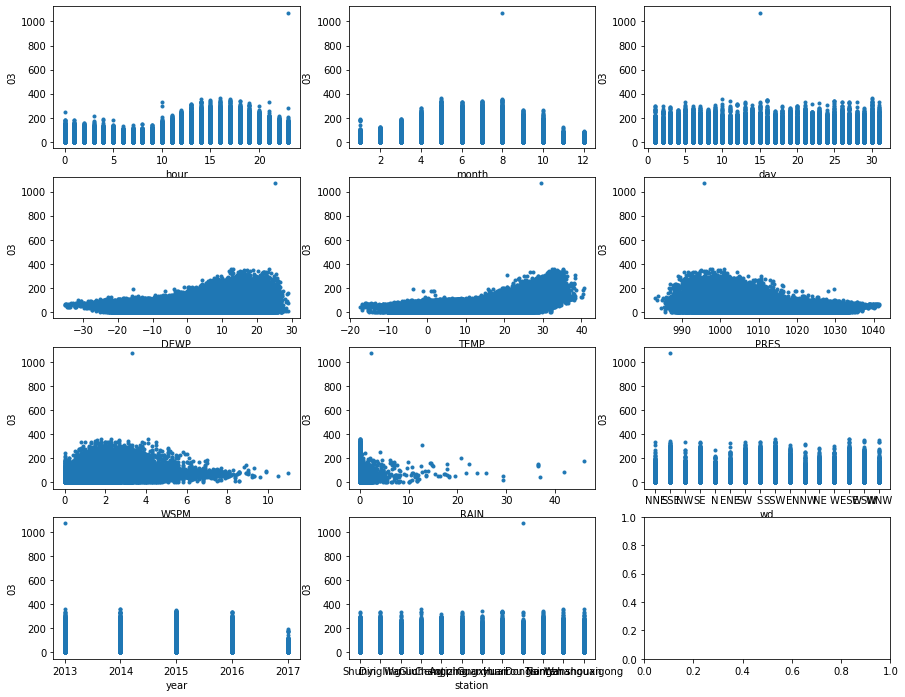

In [6]:
# plots scatter graph with the mean value of the target for each value of the attribute (string imput)
# log is true when we want to plot it with a logarithmic scale

def plotTargetPerAttribute(data, attribute, ax=plt, logx=False, logy=False) :
    if logx :
        ax.semilogx(data[attribute], data["O3"])
    elif logy :
        ax.semilogy(data[attribute], data["O3"])
    else :
        ax.plot(data[attribute], data["O3"], '.')
    ax.set(xlabel=attribute)
    ax.set(ylabel="03")
    #ax.savefig("./max_iter_ppn.pdf")

def plotAllAttributes(data) :
    plt.clf()
    fig, axs = plt.subplots(4,3, figsize = (15,12))
    j = -1
    for i in range(11) :
        attribute = attributes[i]
        plotTargetPerAttribute(data, attribute, axs[j][i%3])
        if i%3 == 0:
            j += 1
    plt.savefig("../figures/airquality/plot_all_attributes.jpeg")

plotAllAttributes(df)

In [7]:
def removeOutliers(df) :
    if 'O3' in df.columns :
        df = df[df['O3'] < 1000]
    return df

from sklearn.preprocessing import MinMaxScaler

# scaling with min-max, useful only for KNN imputation

def scaling(df) :
    num_columns = ["year","month","day","hour","TEMP","PRES","DEWP","RAIN","WSPM"]
    scaler = MinMaxScaler()
    df_num = df[num_columns]
    df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=num_columns)
    for col in num_columns:
        df[col] = df_num[col]
    return df
    
# get the O3 index
indO3 = None

# returns the 5 datasets with the 5 methods of preprocessing

def preprocessing(df) :
    # encode columns by one hot
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    removeOutliers(df)
    df = scaling(df)

    df1 = dropRows(df, thres=0, imputation=None)
    df2 = dropRows(df, wds=wds, thres=4, imputation="mean")
    df3 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="mean")
    df4 = dropRows(df, wds=wds, thres=4, imputation="5NN")
    df5 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="5NN")
    DF = [df1,df2,df3,df4,df5]
    for i in range(len(DF)) :
        DF[i] = np.array(DF[i]).astype("float")
    return DF
 
def preprocessing_mean(df) :
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    df = dropRows(df, thres=(len(df_origin)-1), imputation="mean")
    df = removeOutliers(df)
    return np.array(df).astype("float")

In [8]:
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2 = [[] for i in range(5)], [[] for i in range(5)]
M5regressor_MAE_model, const_regressor_MAE = [[] for i in range(5)], [[] for i in range(5)]

# We split the data and apply the pre-processing

for train_index, test_index in split:
        array_train = df_origin.iloc[train_index]
        array_test = df_origin.iloc[test_index]
        
        trains = preprocessing(pd.DataFrame(data=array_train, columns=df_origin.columns))
        tests = preprocessing(pd.DataFrame(data=array_test, columns=df_origin.columns))

        for i in range(5) :
            y_train = trains[i][:,indO3]
            y_test = tests[i][:,indO3]
            X_train = np.delete(trains[i], indO3, axis=1)
            X_test = np.delete(tests[i], indO3, axis=1)
            
            if y_train.isnan().any() or y_test.isnan().any() or X_train.isnan().any() or X_test.isnan().any() :
                print("nan")
                break
                
            #M5 regressor tree own
            reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
            M5regressor_r2_model[i].append(r2_score(y_test, reg.predict(X_test)))
            M5regressor_MAE_model[i].append(mean_absolute_error(y_test, reg.predict(X_test)))

            #Constant regressor tree own
            reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
            const_regressor_r2[i].append(r2_score(y_test, reg2.predict(X_test)))
            const_regressor_MAE[i].append(mean_absolute_error(y_test, reg2.predict(X_test)))
            
m5_r2, cons_r2 = [], []
for i in range(5):
    m5_r2.append(np.mean(M5regressor_r2_model[i]))
    cons_r2.append(np.mean(const_regressor_r2[i]))

print("m5_r2:", m5_r2)
print("cons_r2:", cons_r2)

KeyboardInterrupt: 

# Parameters tuning

We can notice that the difference can be ignored, so we will use the mean without deleting any value.

# Constant regressor tree

In [ ]:
# preprocessing with only mean value
# we use a simple split and just optimize the train part and have a regard to the test part (or validation) in order 
# to avoid overfitting. We do not use grid search because it is too time costly.

train_set, test_set = train_test_split(df_origin, test_size=0.2, random_state=42)
train_set = preprocessing_mean(train_set)
test_set = preprocessing_mean(test_set)
train_target = trains[i][:,indO3]
test_target = tests[i][:,indO3]
train = np.delete(trains[i], indO3, axis=1)
test = np.delete(tests[i], indO3, axis=1)

# number of cross validation
cv = 2

# maximum depth
vals = np.arange(4,23,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = 4, max_depth=x).fit(train, train_target[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_cons.jpeg")

The optimal depth seems to be 8. Now we optimize the number of attributes per leaf.

In [ ]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = x, max_depth=8).fit(train, train_target[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_cons.jpeg")

The optimal number of attributes per leaf could be 4. We will use these parameters to compare to the other algorithms.

# M5 regressor tree

In [ ]:
# max depth
vals = np.arange(2,15,2)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=x,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_M5.jpeg")

It seems that the best value is 12 because we overfit after that.

In [ ]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=x, max_depth=6,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_M5.jpeg")

It seems not to change a lot, let's take the default value.

In [ ]:
# k
vals = np.arange(5,31,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=x,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/k_M5.jpeg")

k=12 seems quite optimal to avoid overfitting.

In [ ]:
# pruning
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/pruning_M5.jpeg")

We need pruning to avoid overfitting.

In [ ]:
# smoothing
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/smoothing_M5.jpeg")

We need smoothing to avoid overfitting.

In [ ]:
# optimize models
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=x,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/opti_model_M5.jpeg")

There is no real difference so we will still optimize models.

In [ ]:
# incremental fit
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=x).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/incr_fit_M5.jpeg")

We need incremental fit to avoid overfitting.

# Compare with existing algorithms

We can notice that the difference can be ignored, so we will just delete the samples with missing data during the preprocessing phase.

In [ ]:
import timeit

kf = KFold(n_splits=10, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2, const_regressor_sklearn_r2_model, linear_regressor_r2, random_forest_regressor_r2, extra_tree_r2 = [], [], [], [], [], []
M5regressor_MAE_model, const_regressor_MAE, const_regressor_sklearn_MAE_model, linear_regressor_MAE, random_forest_regressor_MAE, extra_tree_MAE = [], [], [], [], [], []
times = {"M5":-1, "cons":-1, "cons_sk":-1, "linear":-1, "random_forest":-1, "extratree":-1}

# We split the data and apply the pre-processing

for train_index, test_index in split:
    
        train_set = preprocessing_mean(df_origin.iloc[train_index])
        test_set = preprocessing_mean(df_origin.iloc[test_index])
        y_train = trains[i][:,indO3]
        y_test = tests[i][:,indO3]
        X_train = np.delete(trains[i], indO3, axis=1)
        X_test = np.delete(tests[i], indO3, axis=1)

        #M5 regressor tree own
        start = timeit.default_timer()
        reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
        M5regressor_r2_model.append(r2_score(y_test, reg.predict(X_test)))
        M5regressor_MAE_model.append(mean_absolute_error(y_test, reg.predict(X_test)))
        times["M5"] = timeit.default_timer()-start
        
        #Constant regressor tree own
        start = timeit.default_timer()
        reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
        const_regressor_r2.append(r2_score(y_test, reg2.predict(X_test)))
        const_regressor_MAE.append(mean_absolute_error(y_test, reg2.predict(X_test)))
        times["cons"] = timeit.default_timer()-start
        
        #Constant regressor tree SKlearn #SAME PARAMETERS AS OURS?
        start = timeit.default_timer()
        const_regressor_sklearn = tree.DecisionTreeRegressor(min_samples_leaf=4, max_depth=8, random_state=42).fit(X_train, y_train)
        const_regressor_sklearn_r2_model.append(r2_score(y_test, const_regressor_sklearn.predict(X_test)))
        const_regressor_sklearn_MAE_model.append(mean_absolute_error(y_test, const_regressor_sklearn.predict(X_test)))
        times["cons_sk"] = timeit.default_timer()-start
        #Linear regression sklearn
        start = timeit.default_timer()
        linear_regressor = LinearRegression().fit(X_train, y_train)
        linear_regressor_r2.append(r2_score(y_test, linear_regressor.predict(X_test)))
        linear_regressor_MAE.append(mean_absolute_error(y_test, linear_regressor.predict(X_test)))
        times["linear"] = timeit.default_timer()-start
        # Random forrest regressor
        start = timeit.default_timer()
        random_forest_regressor = RandomForestRegressor(max_depth=8, min_samples_split=4, random_state=42).fit(X_train, y_train)
        random_forest_regressor_r2.append(r2_score(y_test, random_forest_regressor.predict(X_test)))
        random_forest_regressor_MAE.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))
        times["random_forest"] = timeit.default_timer()-start
        #Extra tree regressor
        start = timeit.default_timer()
        extra_tree_regressor = ExtraTreeRegressor(max_depth=8, random_state=42).fit(X_train, y_train)
        extra_tree_r2.append(r2_score(y_test, extra_tree_regressor .predict(X_test)))
        extra_tree_MAE.append(mean_absolute_error(y_test, extra_tree_regressor .predict(X_test)))
        times["extratree"] = timeit.default_timer()-start


m5_r2 = np.mean(M5regressor_r2_model)
cons_r2 = np.mean(const_regressor_r2)                                           
cons_sklearn_r2 = np.mean(const_regressor_sklearn_r2_model)   
linear_r2 = np.mean(linear_regressor_r2)
random_r2 =np.mean(random_forest_regressor_r2)
extra_r2= np.mean(extra_tree_r2)
m5_MAE = np.mean(M5regressor_MAE_model)
cons_MAE = np.mean(const_regressor_MAE)                                           
cons_sklearn_MAE = np.mean(const_regressor_sklearn_MAE_model)   
linear_MAE = np.mean(linear_regressor_MAE)
random_MAE =np.mean(random_forest_regressor_MAE)
extra_MAE = np.mean(extra_tree_MAE)
print("m5 r2", m5_r2, "MAE", m5_MAE )
print("cons r2",cons_r2, "MAE", cons_MAE  )
print("cons_sklearn r2", cons_sklearn_r2, "MAE", cons_sklearn_MAE) 
print("linear r2", linear_r2, "MAE", linear_MAE)
print("random r2", random_r2, "MAE", random_MAE)
print("extra r2", extra_r2, "MAE", extra_MAE)
print(times)

In [ ]:
objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
r2score = [m5_r2,cons_r2,cons_sklearn_r2,linear_r2,random_r2,1]

plt.bar(y_pos, r2score, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('R2 score')
plt.title('R2 score per model')
plt.savefig("../figures/airquality/r2scores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
MAEscore = [m5_MAE,cons_MAE,cons_sklearn_MAE,linear_MAE,random_MAE,1]

plt.bar(y_pos, MAEscore, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('MAE score')
plt.title('MAE score per model')
plt.savefig("../figures/airquality/MAEscores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))

plt.bar(y_pos, times.values(), align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Execution time per model')